In [1]:
import sys
sys.path.insert(0, "/cndd/fangming/CEMBA/snmcseq_dev")

from multiprocessing import Pool,cpu_count
from functools import partial

from scipy import sparse
from scipy import stats
import importlib
from __init__ import *
from __init__jupyterlab import *
import snmcseq_utils
importlib.reload(snmcseq_utils)

import re
import pickle
import datetime
from scipy import optimize

import tqdm

import importlib
sys.path.insert(0, '../')
import enhancer_gene_utils
importlib.reload(enhancer_gene_utils)

<module 'enhancer_gene_utils' from '../enhancer_gene_utils.py'>

In [2]:
today = datetime.date.today()
print(today)

2021-01-07


# Get grand summary 
### - 80% cells for 5-time downsampling

In [3]:
input_enh_gene_table = '/cndd2/fangming/projects/scf_enhancers/results/200521_to_evals.tsv' 
output_res = '/cndd2/fangming/projects/scf_enhancers/results/{}_metacell_corr_res_{{}}'.format(today)
print(output_res)

/cndd2/fangming/projects/scf_enhancers/results/2021-01-07_metacell_corr_res_{}


In [4]:
# enhancer-gene linkage
ti = time.time()
enhancer_gene_to_eval = (pd.read_csv(input_enh_gene_table, sep='\t')
                             [['gene', 'ens', 'dist']]
                             .rename(columns={'ens': 'enh'})
                        )

print(enhancer_gene_to_eval.shape)
print(time.time()-ti)
enhancer_gene_to_eval.head()

(2589994, 3)
10.998602867126465


,gene,enh,dist
0,ENSMUSG00000000001,147520,995118
1,ENSMUSG00000000001,147522,985740
2,ENSMUSG00000000001,147523,983725
3,ENSMUSG00000000001,147527,970444
4,ENSMUSG00000000001,147528,969372


In [5]:
# get all clusterings
def get_isub_clstfile(fname):
    """Subsampling index
    """
    pattern = '_sub[0-9]+.tsv.gz' 
    isub = int(re.findall(pattern, fname)[0][len("_sub"):-len('.tsv.gz')])
    return isub 

def get_knn_clstfile(fname):
    """cross-modal knn
    """
    pattern = '_knn[0-9]+_' 
    knn = int(re.findall(pattern, fname)[0][len("_knn"):-len('_')])
    return knn 

f_pattern = ("/cndd2/fangming/projects/miniatlas/results/"
             "clusterings_10x_cells_v3_mop_10x_cells_v3_snmcseq_gene_ka30_knn*_201228_sub*.tsv.gz"
             )

fnames = np.sort(glob.glob(f_pattern))
iterator_clsts = pd.DataFrame([{'i': get_isub_clstfile(fname),
                                'k': get_knn_clstfile(fname),
                                'fname': fname,
                              } for fname in fnames])
print(iterator_clsts.shape)

res_clsts = []
for idx, row in tqdm.tqdm(iterator_clsts.iterrows()):
    isub = row['i']
    knn = row['k']
    fname = row['fname']
    
    df = pd.read_csv(fname, index_col=0, sep='\t')
    for col in df.columns:
        r = float(col[len('cluster_r'):])
        num_clst = len(df[col].unique())
        res_clsts.append({
            'k': knn,
            'i': isub,
            'r': r,
            'num_clst': num_clst,
        })
#     break
res_clsts = pd.DataFrame(res_clsts)
# a little hack
res_clsts['rM'] = (res_clsts['r']*1e6).astype(int)

print(res_clsts.shape)
res_clsts.head()

0it [00:00, ?it/s]

(1, 3)


1it [00:00,  2.45it/s]

(41, 5)


,k,i,r,num_clst,rM
0,30,0,1.000000,16,1000000
1,30,0,1.258925,20,1258925
2,30,0,1.584893,23,1584893
3,30,0,1.995262,30,1995262
4,30,0,2.511886,33,2511886


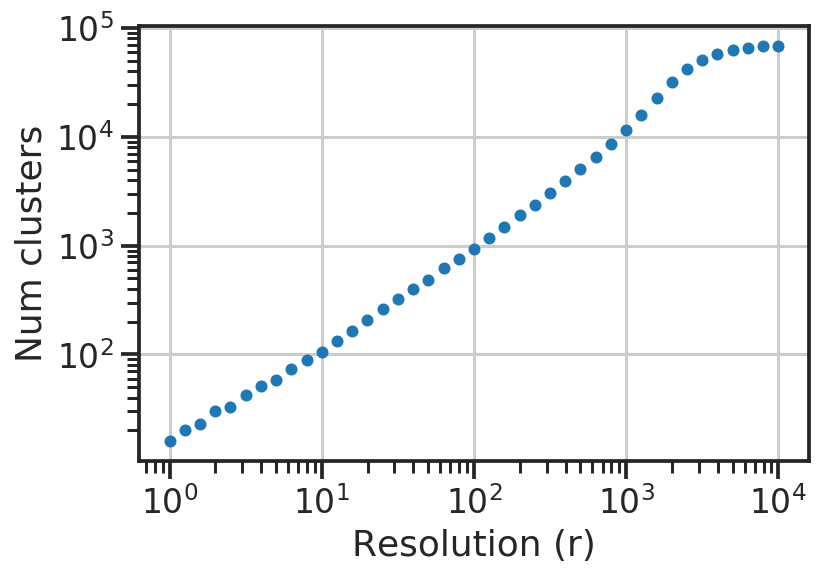

In [6]:
fig, ax = plt.subplots()
ax.plot(res_clsts['r'].values, res_clsts['num_clst'].values, 'o', markersize=5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Resolution (r)')
ax.set_ylabel('Num clusters')
plt.show()

In [7]:
bins = np.linspace(-1,1,201)
fdr_threshold = 0.2
distance_threshold = 1e5
label = 'pairs (<100kb)'

col_orders = [
            'num_linked_pairs',
            'num_linked_genes',
            'num_linked_enhs',
            'id_linked_pairs',
    
            'num_correlated_pairs',
            'num_correlated_genes',
            'num_correlated_enhs',
            'id_correlated_pairs',
    
            'num_total_pairs',
            'num_total_genes',
            'num_total_enhs',
            'id_total_pairs',
    
            'r_th_linked', 
            'r_th_correlated_left',
            'r_th_correlated_right',
    ]

In [8]:
# get all (shared) corr analyses
def get_resolution(fname):
    """Resolution
    """
    resolution_pattern = '_cluster_r[0-9.]+_' 
    r = float(re.findall(resolution_pattern, fname)[0][len("_cluster_r"):-len('_')])
    return r
    
def get_isub(fname):
    """Subsampling index
    """
    pattern = '_[0-9]_cluster' 
    isub = int(re.findall(pattern, fname)[0][len("_"):-len('_cluster')])
    return isub 

def get_isub2(fname):
    """Subsampling index
    """
    pattern = '_[0-9]_f[0-9]_cluster' 
    isub = int(re.findall(pattern, fname)[0][len("_"):-len('_fX_cluster')])
    return isub 

def get_ifsub(fname):
    """Subsampling feauture index
    """
    pattern = '_[0-9]_f[0-9]_cluster' 
    i_fsub = int(re.findall(pattern, fname)[0][len("_X_f"):-len('_cluster')])
    return i_fsub 

def get_knn(fname):
    """cross-modal knn
    """
    pattern = '_knn[0-9]+_' 
    knn = int(re.findall(pattern, fname)[0][len("_knn"):-len('_')])
    return knn 



# mC
f_pattern = ("/cndd2/fangming/projects/scf_enhancers/results/"
             "mop_10x_cells_v3_snmcseq_gene_ka30_knn*_210101"
             "_[0-9]_f[0-9]_cluster_r*_spearmanr_insample_corrs.pkl"
            )
fnames = np.sort(glob.glob(f_pattern))
iterator_mc = pd.DataFrame([{'r': get_resolution(fname),
                             'i': get_isub2(fname),
                             'if': get_ifsub(fname),
                             'k': get_knn(fname),
                             'fname_mc': fname,
                          } for fname in fnames])
# a little hack to avoid merge on float number
iterator_mc['rM'] = (iterator_mc['r']*1e6).astype(int)
print(iterator_mc.shape)

# mC - new
f_pattern = ("/cndd2/fangming/projects/scf_enhancers/results/"
             "mop_10x_cells_v3_snmcseq_gene_ka30_knn*_210101"
             "_[0-9]_f[0-9]_cluster_r*_spearmanr_outsample_corrs.pkl"
            )
fnames = np.sort(glob.glob(f_pattern))
iterator_mc2 = pd.DataFrame([{'r': get_resolution(fname),
                              'i': get_isub2(fname),
                              'if': get_ifsub(fname),
                              'k': get_knn(fname),
                              'fname_mc_out': fname,
                          } for fname in fnames])
iterator_mc2['rM'] = (iterator_mc2['r']*1e6).astype(int)
print(iterator_mc2.shape)

# ATAC
f_pattern = ("/cndd2/fangming/projects/scf_enhancers/results/"
             "mop_10x_cells_v3_snatac_gene_ka30_knn*_210101"
             "_[0-9]_f[0-9]_cluster_r*_spearmanr_insample_corrs.pkl"
            )
fnames = np.sort(glob.glob(f_pattern))
iterator_atac = pd.DataFrame([{'r': get_resolution(fname),
                               'i': get_isub2(fname),
                               'if': get_ifsub(fname),
                               'k': get_knn(fname),
                               'fname_atac': fname,
                              } for fname in fnames])
iterator_atac['rM'] = (iterator_atac['r']*1e6).astype(int)
print(iterator_atac.shape)

# ATAC - new
f_pattern = ("/cndd2/fangming/projects/scf_enhancers/results/"
             "mop_10x_cells_v3_snatac_gene_ka30_knn*_210101"
             "_[0-9]_f[0-9]_cluster_r*_spearmanr_outsample_corrs.pkl"
            )
fnames = np.sort(glob.glob(f_pattern))
iterator_atac2 = pd.DataFrame([{'r': get_resolution(fname),
                                'i': get_isub2(fname),
                                'if': get_ifsub(fname),
                                'k': get_knn(fname),
                                'fname_atac_out': fname,
                              } for fname in fnames])
iterator_atac2['rM'] = (iterator_atac2['r']*1e6).astype(int)
print(iterator_atac2.shape)

# merge all
iterator_both = pd.merge(iterator_mc, iterator_atac.drop('r', axis=1), on=['k', 'rM', 'i', 'if'])
iterator_both = pd.merge(iterator_both, iterator_mc2.drop('r', axis=1), on=['k', 'rM', 'i', 'if'])
iterator_both = pd.merge(iterator_both, iterator_atac2.drop('r', axis=1), on=['k', 'rM', 'i', 'if'])

iterator_both = iterator_both.sort_values(['r', 'i', 'if', 'k'])

print(iterator_both.shape)
iterator_both.head()

(469, 6)
(450, 6)
(450, 6)
(450, 6)
(450, 9)


,r,i,if,k,fname_mc,rM,fname_atac,fname_mc_out,fname_atac_out
360,1.0,0,0,5,/cndd2/fangming/projects/scf_enhancers/results...,1000000,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...
90,1.0,0,0,10,/cndd2/fangming/projects/scf_enhancers/results...,1000000,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...
180,1.0,0,0,30,/cndd2/fangming/projects/scf_enhancers/results...,1000000,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...
270,1.0,0,0,50,/cndd2/fangming/projects/scf_enhancers/results...,1000000,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...
0,1.0,0,0,100,/cndd2/fangming/projects/scf_enhancers/results...,1000000,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...


In [9]:
# calc corr
res_corr = enhancer_gene_utils.get_corr_stats(iterator_both[['fname_mc', 'fname_atac']], #.iloc[[0,1]], 
                                              enhancer_gene_to_eval, col_orders) 
res_corr_out = enhancer_gene_utils.get_corr_stats(iterator_both[['fname_mc_out', 'fname_atac_out']]
                                                        .rename(columns={
                                                            'fname_mc_out': 'fname_mc',
                                                            'fname_atac_out': 'fname_atac',
                                                        }), #.iloc[[0,1]], 
                                                  enhancer_gene_to_eval, col_orders) 
iterator_both = iterator_both.join(res_corr)
iterator_both = iterator_both.join(res_corr_out, lsuffix='_in', rsuffix='_out')

# merge with res_clsts
iterator_both = pd.merge(iterator_both, res_clsts.drop('r', axis=1), on=['rM', 'i', 'k'], how='inner')
print(iterator_both.shape)

13it [00:18,  1.45s/it]

failed to detect r_threshold:


450it [08:40,  1.16s/it]
0it [00:00, ?it/s]

(450, 39)


450it [09:35,  1.28s/it]

(450, 39)
(90, 88)


In [10]:
print(iterator_both.shape)
iterator_both.head()

(90, 88)


,r,i,if,k,fname_mc,rM,fname_atac,fname_mc_out,fname_atac_out,num_linked_pairs_mc_in,...,num_linked_pairs_both_out,num_linked_genes_both_out,num_linked_enhs_both_out,num_correlated_pairs_both_out,num_correlated_genes_both_out,num_correlated_enhs_both_out,num_total_pairs_both_out,num_total_genes_both_out,num_total_enhs_both_out,num_clst
0,1.000000,0,0,30,/cndd2/fangming/projects/scf_enhancers/results...,1000000,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...,1722,...,51,32,49,1797,777,1595,46437,3491,21122,16
1,1.000000,0,1,30,/cndd2/fangming/projects/scf_enhancers/results...,1000000,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...,1903,...,25,22,24,6487,2160,5305,83891,6148,35094,16
2,1.000000,0,2,30,/cndd2/fangming/projects/scf_enhancers/results...,1000000,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...,886,...,34,23,34,4396,1381,3621,46561,3729,20869,16
3,1.258925,0,0,30,/cndd2/fangming/projects/scf_enhancers/results...,1258925,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...,1882,...,78,44,77,6297,1669,4915,46437,3491,21122,20
4,1.258925,0,1,30,/cndd2/fangming/projects/scf_enhancers/results...,1258925,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...,2211,...,84,60,80,13640,3448,10243,83891,6148,35094,20


In [11]:
# save this bit
output = output_res.format('grand_res_summary_table.tsv.gz')
print(output)
iterator_both.to_csv(output, sep='\t', header=True, index=False)

/cndd2/fangming/projects/scf_enhancers/results/2021-01-07_metacell_corr_res_grand_res_summary_table.tsv.gz


In [12]:
iterator_both = pd.read_csv(output, sep='\t')
print(iterator_both.shape)
iterator_both.head()

(90, 88)


,r,i,if,k,fname_mc,rM,fname_atac,fname_mc_out,fname_atac_out,num_linked_pairs_mc_in,...,num_linked_pairs_both_out,num_linked_genes_both_out,num_linked_enhs_both_out,num_correlated_pairs_both_out,num_correlated_genes_both_out,num_correlated_enhs_both_out,num_total_pairs_both_out,num_total_genes_both_out,num_total_enhs_both_out,num_clst
0,1.000000,0,0,30,/cndd2/fangming/projects/scf_enhancers/results...,1000000,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...,1722,...,51,32,49,1797,777,1595,46437,3491,21122,16
1,1.000000,0,1,30,/cndd2/fangming/projects/scf_enhancers/results...,1000000,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...,1903,...,25,22,24,6487,2160,5305,83891,6148,35094,16
2,1.000000,0,2,30,/cndd2/fangming/projects/scf_enhancers/results...,1000000,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...,886,...,34,23,34,4396,1381,3621,46561,3729,20869,16
3,1.258925,0,0,30,/cndd2/fangming/projects/scf_enhancers/results...,1258925,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...,1882,...,78,44,77,6297,1669,4915,46437,3491,21122,20
4,1.258925,0,1,30,/cndd2/fangming/projects/scf_enhancers/results...,1258925,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...,2211,...,84,60,80,13640,3448,10243,83891,6148,35094,20


In [13]:
iterator_both.columns

Index(['r', 'i', 'if', 'k', 'fname_mc', 'rM', 'fname_atac', 'fname_mc_out',
       'fname_atac_out', 'num_linked_pairs_mc_in', 'num_linked_genes_mc_in',
       'num_linked_enhs_mc_in', 'id_linked_pairs_mc_in',
       'num_correlated_pairs_mc_in', 'num_correlated_genes_mc_in',
       'num_correlated_enhs_mc_in', 'id_correlated_pairs_mc_in',
       'num_total_pairs_mc_in', 'num_total_genes_mc_in',
       'num_total_enhs_mc_in', 'id_total_pairs_mc_in', 'r_th_linked_mc_in',
       'r_th_correlated_left_mc_in', 'r_th_correlated_right_mc_in',
       'num_linked_pairs_atac_in', 'num_linked_genes_atac_in',
       'num_linked_enhs_atac_in', 'id_linked_pairs_atac_in',
       'num_correlated_pairs_atac_in', 'num_correlated_genes_atac_in',
       'num_correlated_enhs_atac_in', 'id_correlated_pairs_atac_in',
       'num_total_pairs_atac_in', 'num_total_genes_atac_in',
       'num_total_enhs_atac_in', 'id_total_pairs_atac_in',
       'r_th_linked_atac_in', 'r_th_correlated_left_atac_in',
       'r_t